# Homework 2
Kristina, Marion and Alexandre

In [561]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import warnings

# Global variables


In [562]:
max_rank = 200 # Keep only the first 200 universities

In [563]:
def plot_data_bar(data, ax, attr='', xdata='', title=''):
    
    ax.grid()
    if attr == 'index':
        ax.set_xlabel(data.index)
        sns.barplot(x=xdata, y=data.index, data=data, ax=ax, palette="Greens_r")
    else:
        ax.set_xlabel(data[attr])
        sns.barplot(x=xdata, y=data[attr], data=data, ax=ax, palette="Greens_r")

    ax.set_title(title, fontsize=14, fontweight='bold')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

# First ranking - www.topuniversities.com

## Handle data

This ranking is also known as <i>QS University Ranking</i>.<br>
We see with <b>Postman</b> that a .txt file in a JSON format is loaded with the page. This file contains all universities with all the ranking informations displayed on the page.

In [564]:
URL_PATH_QS = 'https://www.topuniversities.com'
RANKING_DATA_URL_QS = URL_PATH_QS + '/sites/default/files/qs-rankings-data/357051.txt'
response_qs = requests.get(RANKING_DATA_URL_QS)  # HTTP GET request

raw_data_qs = json_normalize(response_qs.json(), 'data')

In [565]:
top200_qs = raw_data_qs[: max_rank]

Once we have the 200 top universities, we want to get more informations like :
- number of faculty members (international and total) 
- number of students (international and total)

These informations are not contained in the main page of the ranking, but in university details page.<br> 
Each university has a url attribute which allow us to make a GET request on each details page, in order to extract the data we need with BeautifulSoup.<br> This step can be slow because of the 200 GET requests we have to do.

In [566]:
def str_to_numeric(str):
    return int(str.replace(',',''))

def find_numbers(soup, attribute):
    try:
        div = soup.find('div', class_=attribute).find('div', class_="number")
        if div:
            return str_to_numeric(div.text)
        else:
            return 0
    except AttributeError:
        return 0

In [567]:
faculty_staff = []
international_staff = []
total_students = []
international_students = []

for i, row in top200_qs.iterrows():
    
    # Current url of the university
    url = row.url
    
    # Make to GET resquest in the details page
    response = requests.get(URL_PATH + url)
    soup = BeautifulSoup(response.text, 'html.parser') # Parse HTML page with BeaufitulSoup

    # Get number of total academic faculty staff
    total_faculty = find_numbers(soup, 'total faculty')
    # Get number of international academic staff
    inter_faculty = find_numbers(soup, 'inter faculty')
    # Get number of total students
    total_student = find_numbers(soup, 'total student')
    # Get number of international students
    total_inter = find_numbers(soup, 'total inter')
    
    faculty_staff.append(total_faculty)
    international_staff.append(inter_faculty)
    total_students.append(total_student)
    international_students.append(total_inter)
    
    
# Create new dataframes before concatenate with the main one  
total_faculty_staff_df = pd.DataFrame(faculty_staff, columns=['total_faculty_staff'])
international_faculty_staff_df = pd.DataFrame(international_staff, columns=['international_faculty_staff'])
total_students_df = pd.DataFrame(total_students, columns=['total_students'])
international_students_df = pd.DataFrame(international_students, columns=['international_students'])

# Concat the new information in the raw dataframe
top200_qs = pd.concat([top200_qs, total_faculty_staff_df, international_faculty_staff_df, total_students_df, international_students_df], axis=1)

In [568]:
# Data cleaning - Keep only useful information
top200_qs = top200_qs[['title', 'country', 'region', 'total_faculty_staff', 'international_faculty_staff', 'total_students', 'international_students']]

## Compute useful ratios

Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?<br>
<i>Note: the first ratio is the numbers of student for one faculty staff</i>

In [569]:
top200_qs['staff_student_ratio'] = (top200_qs.total_students / top200_qs.total_faculty_staff)   # (a)
top200_qs['international_student_ratio'] = (top200_qs.international_students / top200_qs.total_students) # (b)

### Top 10 universities

In [570]:
top10_qs_1 = top200_qs.sort_values(['staff_student_ratio'], ascending=True).head(10) # Top 10 universities - student/staff ratio
top10_qs_2 = top200_qs.sort_values(['international_student_ratio'], ascending=False).head(10) # Top 10 universities - international student ratio

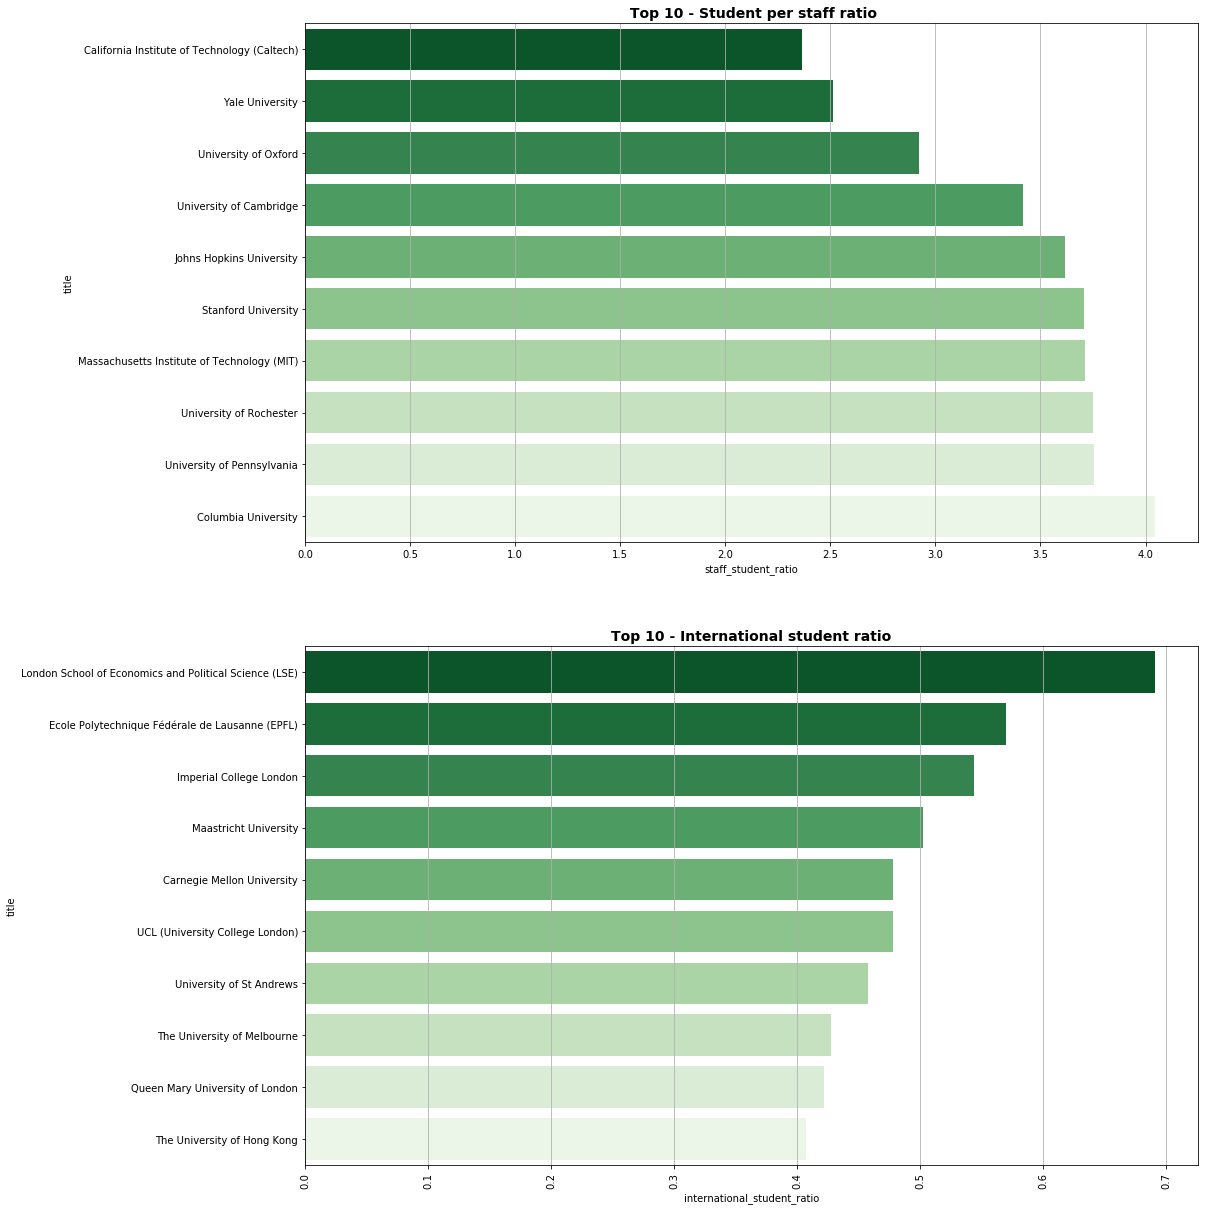

In [571]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar(top10_qs_1, axes[0], 'title', 'staff_student_ratio', ' Top 10 - Student per staff ratio')
plot_data_bar(top10_qs_2, axes[1], 'title', 'international_student_ratio', 'Top 10 - International student ratio')

#### Observations
TODO

### Top countries

In [572]:
# Group by country - mean
top200_qs_country_1 = top200_qs.groupby(['country'])[['staff_student_ratio']].mean()
top200_qs_country_top_1 = top200_qs_country_1.sort_values('staff_student_ratio', ascending=True)

# Group by country - mean
top200_qs_country_2 = top200_qs.groupby(['country'])[['international_student_ratio']].mean()
top200_qs_country_top_2 = top200_qs_country_2.sort_values('international_student_ratio', ascending=False)

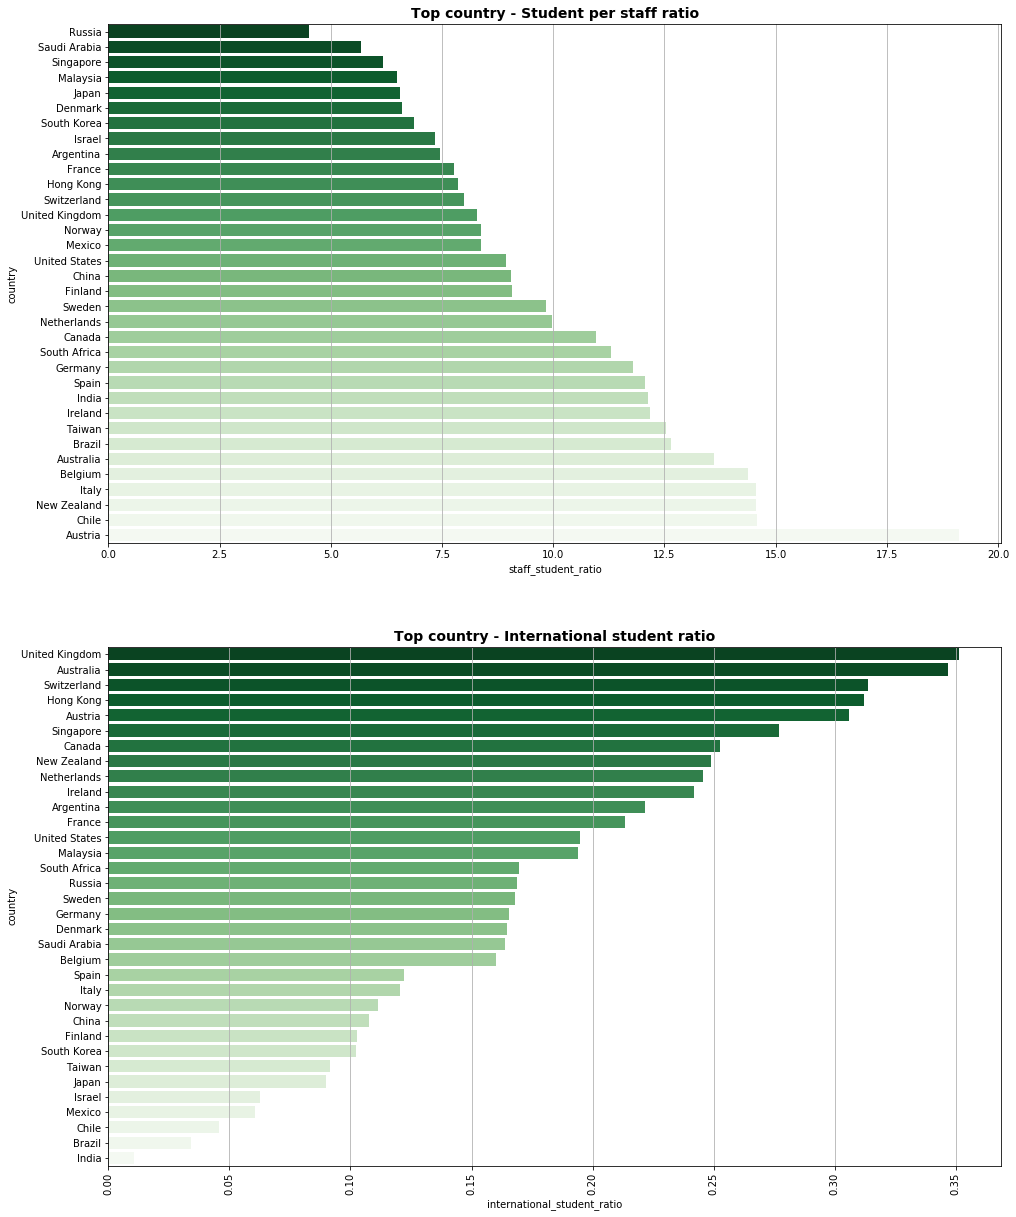

In [573]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar(top200_qs_country_top_1, axes[0], 'index', 'staff_student_ratio', 'Top country - Student per staff ratio')
plot_data_bar(top200_qs_country_top_2, axes[1], 'index', 'international_student_ratio', 'Top country - International student ratio')

#### Observations
TODO

### Top regions

In [574]:
# Group by region - mean
top200_qs_region_1 = top200_qs.groupby(['region'])[['staff_student_ratio']].mean()
top200_qs_region_top_1 = top200_qs_region_1.sort_values('staff_student_ratio', ascending=True)

# Group by region - mean
top200_qs_region_2 = top200_qs.groupby(['region'])[['international_student_ratio']].mean()
top200_qs_region_top_2 = top200_qs_region_2.sort_values('international_student_ratio', ascending=False)

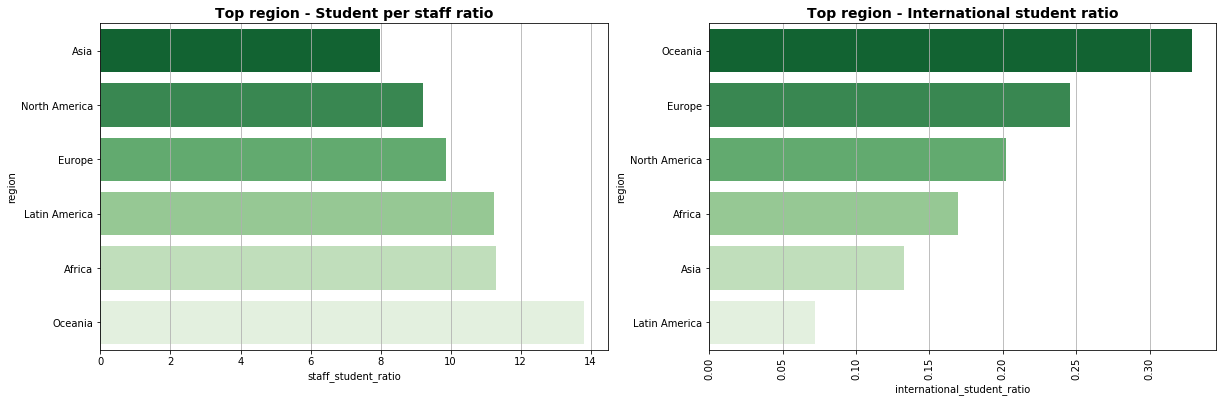

In [575]:
figure, axes = plt.subplots(1, 2, figsize=(20, 6))

plot_data_bar(top200_qs_region_top_1, axes[0], 'index', 'staff_student_ratio', 'Top region - Student per staff ratio')
plot_data_bar(top200_qs_region_top_2, axes[1], 'index', 'international_student_ratio', 'Top region - International student ratio')

#### Observations
TODO

# Second ranking - www.timeshighereducation.com

## Handle data

In [576]:
URL_PATH_THE = 'https://www.timeshighereducation.com'
RANKING_DATA_URL_THE = URL_PATH_THE + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
response_the = requests.get(RANKING_DATA_URL_THE)

raw_data_the = json_normalize(response_the.json(), 'data')
top200_the = raw_data_the[:max_rank]

In [577]:
# Only keep useful informations
top200_the = top200_the[['name', 'location', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio', 'url']]

# Make some data numeric
top200_the['stats_number_students'] = pd.to_numeric(top200_the['stats_number_students'].str.replace(',',''))
top200_the['stats_student_staff_ratio'] = pd.to_numeric(top200_the['stats_student_staff_ratio'])
top200_the['stats_pc_intl_students'] = pd.to_numeric(top200_the['stats_pc_intl_students'].str.replace('%', '')) / 100

## Compute useful ratios

### Top 10 universities

In [578]:
top10_the_1 = top200_the.sort_values(['stats_student_staff_ratio'], ascending=True).head(10) # Top 10 universities - student/staff ratio
top10_the_2 = top200_the.sort_values(['stats_pc_intl_students'], ascending=False).head(10) # Top 10 universities - international student ratio

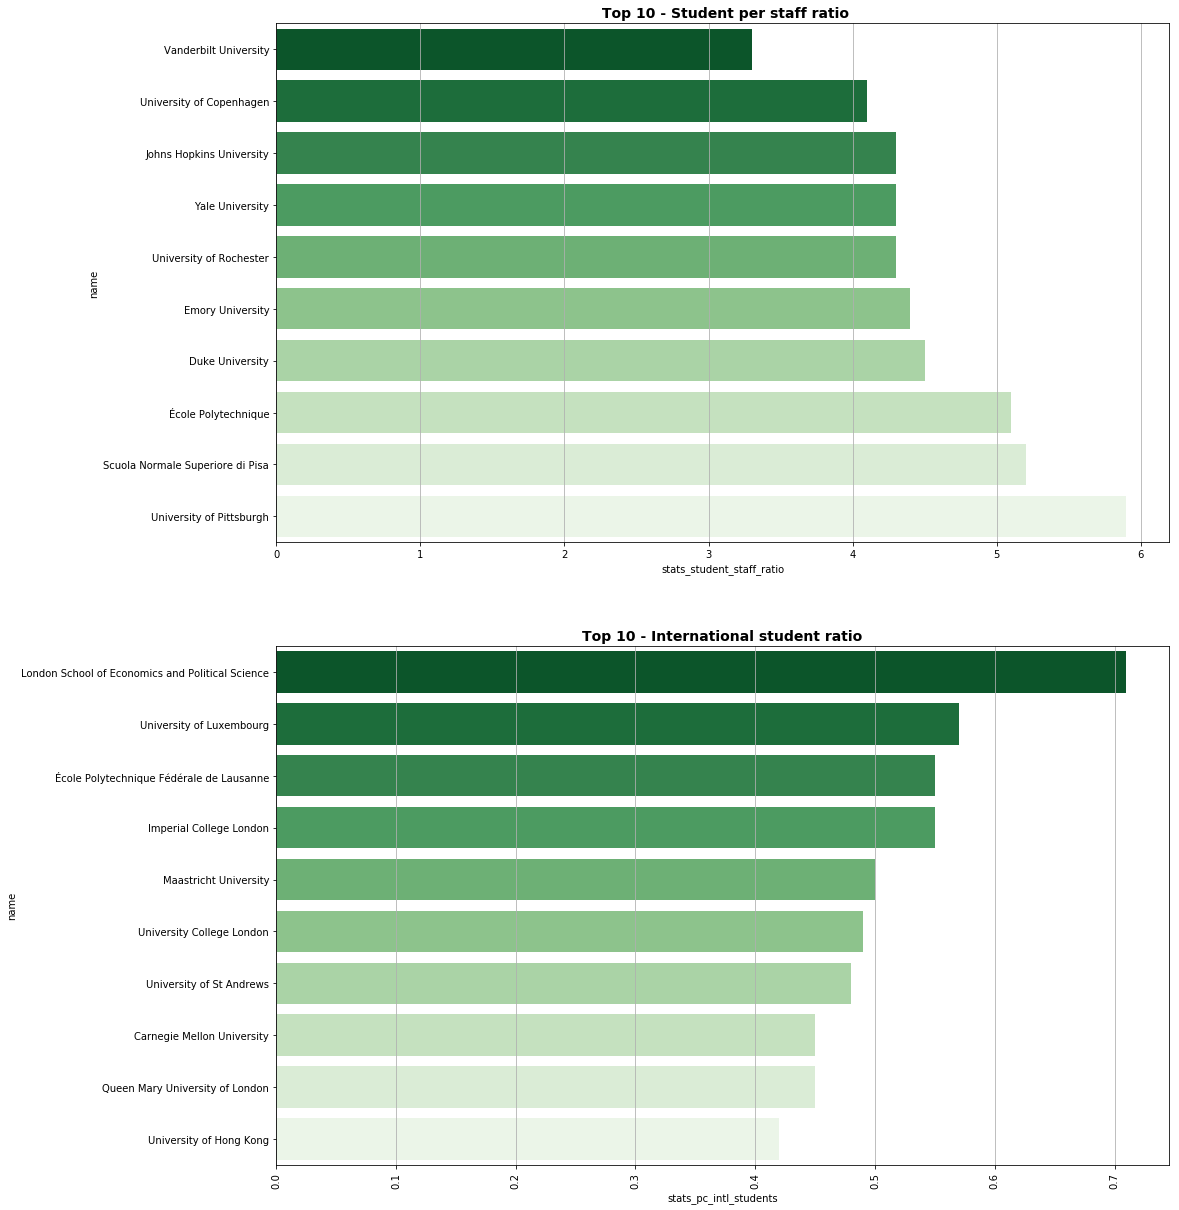

In [579]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar(top10_the_1, axes[0], 'name', 'stats_student_staff_ratio', ' Top 10 - Student per staff ratio')
plot_data_bar(top10_the_2, axes[1], 'name', 'stats_pc_intl_students', 'Top 10 - International student ratio')

#### Observations
TODO

### Top countries

In [580]:
# Group by location - mean
top200_the_country_1 = top200_the.groupby(['location'])[['stats_student_staff_ratio']].mean()
top200_the_country_top_1 = top200_the_country_1.sort_values('stats_student_staff_ratio', ascending=True)

# Group by location - mean
top200_the_country_2 = top200_the.groupby(['location'])[['stats_pc_intl_students']].mean()
top200_the_country_top_2 = top200_the_country_2.sort_values('stats_pc_intl_students', ascending=False)

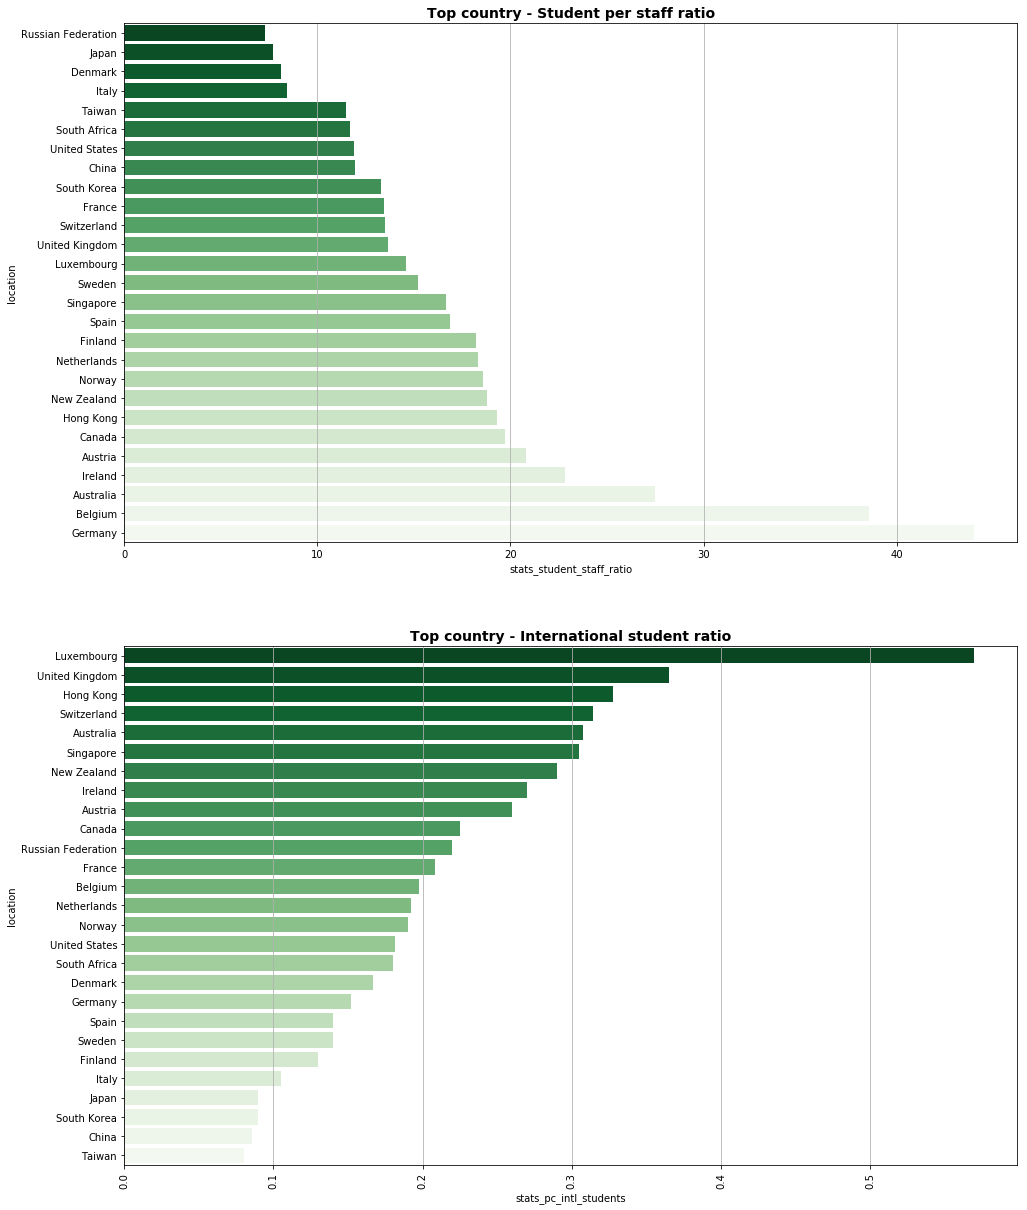

In [581]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar(top200_the_country_top_1, axes[0], 'index', 'stats_student_staff_ratio', 'Top country - Student per staff ratio')
plot_data_bar(top200_the_country_top_2, axes[1], 'index', 'stats_pc_intl_students', 'Top country - International student ratio')

#### Observations
TODO

### Top regions
As we don't have region field in our dataset, we need to get it from the previous DataFrame

In [582]:
top200_the_copy = top200_the.copy()

region_list = top200_qs.groupby(['country', 'region']).size().reset_index()
top200_the_region = pd.merge(top200_the_copy, region_list, how='left', left_on='location', right_on='country')

# Group by region - mean
top200_the_region_1 = top200_the_region.groupby(['region'])[['stats_student_staff_ratio']].mean()
top200_the_region_top_1 = top200_the_region_1.sort_values('stats_student_staff_ratio', ascending=True)

# Group by region - mean
top200_the_region_2 = top200_the_region.groupby(['region'])[['stats_pc_intl_students']].mean()
top200_the_region_top_2 = top200_the_region_2.sort_values('stats_pc_intl_students', ascending=False)

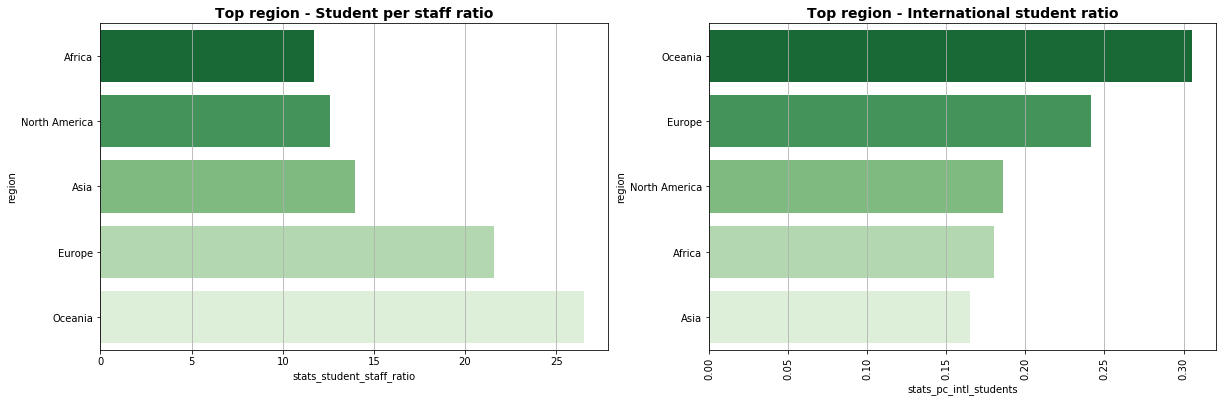

In [583]:
figure, axes = plt.subplots(1, 2, figsize=(20, 6))

plot_data_bar(top200_the_region_top_1, axes[0], 'index', 'stats_student_staff_ratio', 'Top region - Student per staff ratio')
plot_data_bar(top200_the_region_top_2, axes[1], 'index', 'stats_pc_intl_students', 'Top region - International student ratio')

#### Observations
TODO

# Merging the two Dataframes

Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.<br><br>
<b>Our strategy :</b>
- Use <i>SequenceMatcher</i> from difflib library. This class can compare two String objects. Function <i>ratio()</i> returns a float in [0, 1], measuring the similarity of the sequences. For more informations: https://docs.python.org/2/library/difflib.html 
- This ratio is computed and compared with a threshold. If the ratio is more than the threshold, we consider that the two rows are for the same university and we merge them. If the ration is less than the threshold, we simply ignore ignore them.
- Sanitize university names on both dataframes with our function <i>sanitize_data()</i> which put names to lower case and replace a list of common words like 'the', 'of', and common caracters like spaces, parenthesis, ...

In [584]:
from difflib import SequenceMatcher

def similar(a, b):
    a = a.lower()
    b = b.lower()
    
    return SequenceMatcher(None, a, b)

def sanitize_data(c):
    return c.str.lower(). \
    str.replace('universitat','university'). \
    str.replace('universitaet','university'). \
    str.replace('universidad', 'university'). \
    str.replace('universite','university'). \
    str.replace('technische','technology'). \
    str.replace('institute',''). \
    str.replace('science',''). \
    str.replace(r'\(.*\)', ''). \
    str.replace('the ',''). \
    str.replace(' of ',''). \
    str.replace(' at ',''). \
    str.replace(' de ',''). \
    str.replace(' et ',''). \
    str.replace(' and ',''). \
    str.replace(r',|\.',''). \
    str.replace(' ',''). \
    str.replace('\'','')

In [585]:
# Make of copy to be sure
top200_qs_cp = top200_qs.copy()
top200_the_cp = top200_the.copy()

# We consider to use the order defined in the webpage (index) as rank when we have ties
top200_qs_cp['rank_1'] = top200_qs_cp.index + 1
top200_the_cp['rank_2'] = top200_the_cp.index + 1

# Sanitize data and put the nameId generated in a column
top200_qs_cp['name_id'] = sanitize_data(top200_qs_cp.title)
top200_the_cp['name_id'] = sanitize_data(top200_the_cp.name)

In [586]:
for i, row in top200_qs_cp.copy().iterrows():
    max_accuracy = -1.
    accurate_name = 'NaN'
    for name in top200_the_cp.name_id:
        accuracy = similar(row.name_id, name).ratio()
        if (accuracy > max_accuracy) & (accuracy > 0.85):
            max_accuracy = accuracy
            accurate_name = name
            
    top200_qs_cp.at[i, 'max_accuracy'] = max_accuracy
    top200_qs_cp.at[i, 'name_id'] = accurate_name

We can now merge the two dataframes with same <i>name_id</i>

In [587]:
final_top200 = pd.merge(top200_qs_cp, top200_the_cp, left_on='name_id', right_on='name_id')
final_top200

,title,country,region,total_faculty_staff,international_faculty_staff,total_students,international_students,staff_student_ratio,international_student_ratio,rank_1,name_id,max_accuracy,name,location,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,url,rank_2
0,Massachusetts Institute of Technology (MIT),United States,North America,2982,1679,11067,3717,3.711268,0.335863,1,massachusettstechnology,1.000000,Massachusetts Institute of Technology,United States,11177,0.34,8.7,/world-university-rankings/massachusetts-insti...,5
1,Stanford University,United States,North America,4285,2042,15878,3611,3.705484,0.227422,2,stanforduniversity,1.000000,Stanford University,United States,15845,0.22,7.5,/world-university-rankings/stanford-university,4
2,Harvard University,United States,North America,4350,1311,22429,5266,5.156092,0.234785,3,harvarduniversity,1.000000,Harvard University,United States,20326,0.26,8.9,/world-university-rankings/harvard-university,6
3,California Institute of Technology (Caltech),United States,North America,953,350,2255,647,2.366212,0.286918,4,californiatechnology,1.000000,California Institute of Technology,United States,2209,0.27,6.5,/world-university-rankings/california-institut...,3
4,University of Cambridge,United Kingdom,Europe,5490,2278,18770,6699,3.418944,0.356899,5,universitycambridge,1.000000,University of Cambridge,United Kingdom,18389,0.35,10.9,/world-university-rankings/university-cambridge,2
5,University of Oxford,United Kingdom,Europe,6750,2964,19720,7353,2.921481,0.372870,6,universityoxford,1.000000,University of Oxford,United Kingdom,20409,0.38,11.2,/world-university-rankings/university-oxford,1
6,Imperial College London,United Kingdom,Europe,3930,2071,16090,8746,4.094148,0.543567,8,imperialcollegelondon,1.000000,Imperial College London,United Kingdom,15857,0.55,11.4,/world-university-rankings/imperial-college-lo...,8
7,University of Chicago,United States,North America,2449,635,13557,3379,5.535729,0.249244,9,universitychicago,1.000000,University of Chicago,United States,13525,0.25,6.2,/world-university-rankings/university-chicago,9
8,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,2477,1886,19815,7563,7.999596,0.381681,10,ethzurich–swissfederaltechnologyzurich,0.885714,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,19233,0.38,14.6,/world-university-rankings/eth-zurich-swiss-fe...,10
9,"Nanyang Technological University, Singapore (NTU)",Singapore,Asia,4338,2993,25738,7251,5.933149,0.281724,11,nanyangtechnologicaluniversitysingapore,1.000000,"Nanyang Technological University, Singapore",Singapore,25499,0.31,16.3,/world-university-rankings/nanyang-technologic...,52


# Exploratory analysis

## Correlations

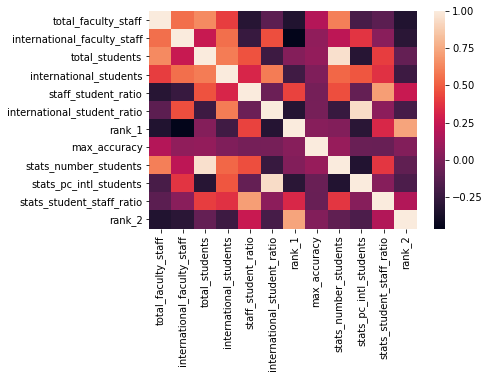

In [588]:
#We can see correlation between columns
import seaborn as sns

corr = final_top200.select_dtypes(['number']).rank().corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Attraction of universities - Faculty staff members
We note in the correlation plot a negative correlation between the number of international faculty members and the rank of the university. This means that, the more international faculty members a university has, the higher it tends to score on the rankings. The rank of a university tends to attract people all around the world.

In [589]:
final_top200[['rank_1', 'international_faculty_staff']].corr()

,rank_1,international_faculty_staff
rank_1,1.000000,-0.483345
international_faculty_staff,-0.483345,1.000000


Then, we estimate and plot a regression model relating to the rank and the number of faculty staff members.

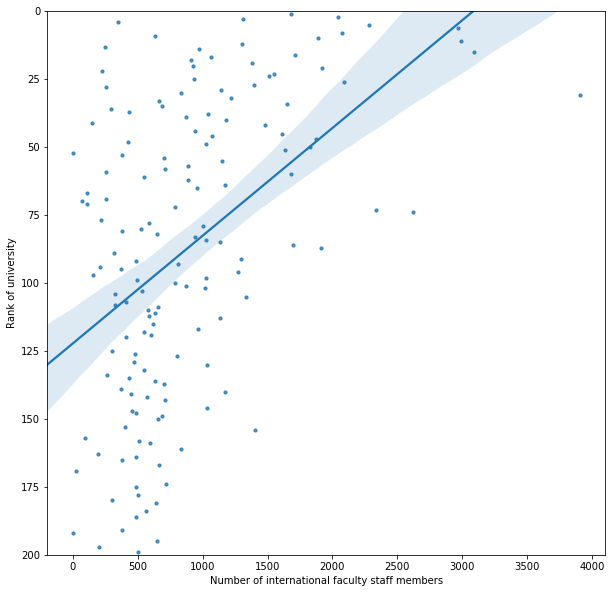

In [590]:
figure, axes = plt.subplots(figsize=(10, 10))

sns.regplot('international_faculty_staff', 'rank_1', data=final_top200, fit_reg=True, scatter_kws={"marker": 'D', "s": 10})
plt.ylim((0,200))
plt.gca().invert_yaxis()
plt.xlabel('Number of international faculty staff members')
plt.ylabel('Rank of university')

### Attraction of universities - International students ratio

We note in the correlation plot a negative correlation between the ratio of international students and the rank of the university. This means that, the higher the percentage of international students a university has, the higher it tends to score on the rankings.

In [591]:
final_top200[['rank_1', 'international_student_ratio']].rank().corr()

,rank_1,international_student_ratio
rank_1,1.000000,-0.320806
international_student_ratio,-0.320806,1.000000


Then, we estimate and plot a regression model relating to the rank and the ratio of international students. We can notice that there is a high variance when the rank approch 1: we have to consider the results carefully.

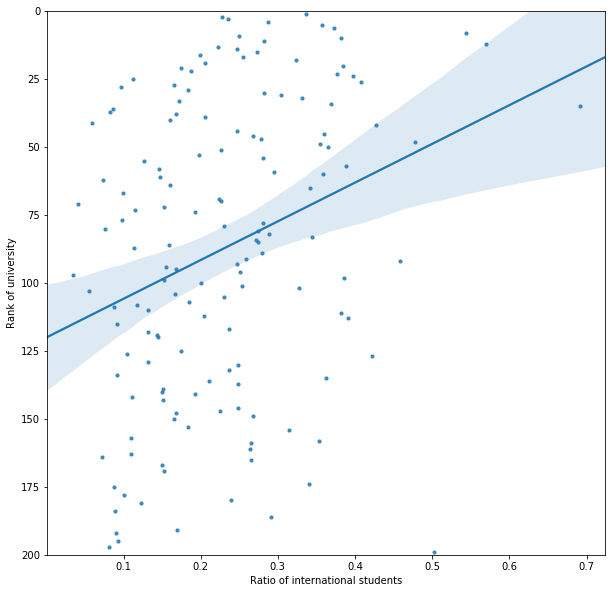

In [592]:
figure, axes = plt.subplots(figsize=(10, 10))

sns.regplot('international_student_ratio', 'rank_1', data=final_top200, fit_reg=True, scatter_kws={"marker": 'D', "s": 10})
plt.ylim((0,200))
plt.gca().invert_yaxis()
plt.xlabel('Ratio of international students')
plt.ylabel('Rank of university')

### Difference between rankings
First, we see a high correlation between the two ranks.

In [593]:
#Trying to see correlation between ranks
final_top200[['rank_1', 'rank_2']].rank().corr()

,rank_1,rank_2
rank_1,1.000000,0.735029
rank_2,0.735029,1.000000


It is interesting to see some statistic values:<br>
- On average, the two rankings agree with each other because the mean is closed to zero.
- The mean is closed to zero too
- However, the standard deviation is quite large : that means a university can have a very high score in one ranking, and a very bad score in another one.

In [594]:
final_top200['diff_rank'] = final_top200['rank_1'] - final_top200['rank_2']
final_top200.diff_rank.describe()

count    150.000000
mean       0.393333
std       42.807184
min     -127.000000
25%      -24.500000
50%        0.000000
75%       24.000000
max      107.000000
Name: diff_rank, dtype: float64

We plot a box that representing theses values.

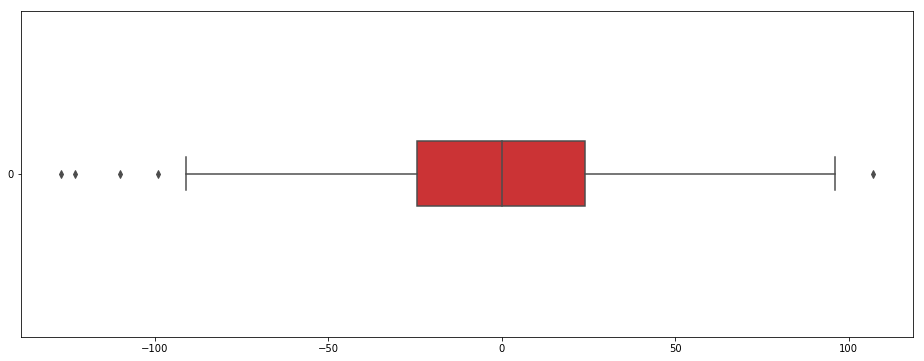

In [595]:
figure, axes = plt.subplots(figsize=(16, 6))
sns.boxplot(data=final_top200['diff_rank'], orient='h', palette="Set1", width=0.2)

# Choosing the best university

Our approch:

In [596]:
fiability_1 = 0.6
fiability_2 = 0.4

final_top200_ratio = final_top200.copy()
final_top200_ratio['rank_ratio'] = fiability_1 * (final_top200_ratio.rank_1 / final_top200_ratio.size) + fiability_2 * (final_top200_ratio.rank_2 / final_top200_ratio.size)

cc = final_top200_ratio.sort_values('rank_ratio').reset_index(drop=True)
cc.index += 1

In [597]:
#Final TOP200 with my assumtions
cc[['title']]

,title
1,Massachusetts Institute of Technology (MIT)
2,Stanford University
3,California Institute of Technology (Caltech)
4,University of Cambridge
5,University of Oxford
6,Harvard University
7,Imperial College London
8,University of Chicago
9,ETH Zurich - Swiss Federal Institute of Techno...
10,Princeton University
